In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import nltk
import jieba
!pip install h3==3.7.0
import h3
from collections import defaultdict
from itertools import combinations

#数据读取转换形式

In [2]:
#读取数据cav
df_json= pd.read_json('input\genai_data_20_json .json', encoding='UTF-8')
df_json.head()
#转换为表格形式(内部嵌套列表,列表里面套字典)
df=pd.DataFrame(df_json)
df.head()

,基础信息,出行关注点,文本,时空信息
0,"{'id': '1', '名字': '小明', '性别': '男'}","[安全, 省时, 不便于行(老人,小孩)]","[今天早上开车去公司，路上车不多。, 打算晚上去健身房后和朋友小聚。, 周末计划带孩子去游乐...","[{'时间': '2024.10.05 08am', '出发点': {'地点': '自家',..."
1,"{'id': '2', '名字': '小红', '性别': '女'}","[重物, 安全, 省钱]","[今天早上搭地铁去学校，列车很准时。, 下午和朋友约好去电影院看电影。, 昨天在超市买菜，发...","[{'时间': '2024.10.06 07am', '出发点': {'地点': '宿舍',..."
2,"{'id': '3', '名字': '李伟', '性别': '男'}","[安全, 愉悦, 准时]","[今天早晨开车去医院，交通顺畅。, 准备晚上和家人一起去餐厅吃饭。, 最近发现一家不错的咖啡...","[{'时间': '2024.10.07 06am', '出发点': {'地点': '家', ..."
3,"{'id': '4', '名字': '张婷', '性别': '女'}","[准时, 愉悦, 安全]","[早晨乘公交去办公室，路上还算顺利。, 中午和同事一起去餐厅吃饭。, 下班后准备去附近的瑜伽...","[{'时间': '2024.10.08 09am', '出发点': {'地点': '家', ..."
4,"{'id': '5', '名字': '王强', '性别': '男'}","[教育意义, 重物, 不便于行(老人,小孩)]","[今天乘地铁去学校上课，地铁很拥挤。, 中午在餐厅吃午饭，同事推荐的不错。, 放学后常去附近...","[{'时间': '2024.10.09 08am', '出发点': {'地点': '家', ..."


#基础信息变成热编码矩阵

In [3]:
# 将基础信息中的性别单独提取为一个新列
df['性别'] = df['基础信息'].apply(lambda x: x.get('性别', None))
# 独热编码性别
#初始化OneHotEncoder
encoder = OneHotEncoder(sparse=False)
#拟合转换数据
b_info = encoder.fit_transform(df[['性别']])##返回的是一个 NumPy 数组
print(b_info)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


#语言信息特征矩阵提取

In [4]:
# 下载载入的停用词
# 读取停用词文件
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stop_words = set(f.read().splitlines())
    return stop_words
stop_words = load_stopwords('input/chinese_stopwords.txt')

In [5]:
# 文本预处理函数
def preprocess_text(text):
    #分词切成集合
    tokens = jieba.lcut(text)
    #过滤停用词
    filtered_tokens = [word for word in tokens if word not in stop_words]
    #用空格作为分割符,将词都连接起来,形成一个新的字符串
    ##separator.join(iterable)字符串方法
    return ' '.join(filtered_tokens)

In [6]:
# 对 '行为记录' 列中的每个文本信息应用预处理，并添加新列到数据 'lan_info'
df['lan_info'] = df['文本'].apply(lambda records: [preprocess_text(text) for text in records])
df.head()
df['lan_info']

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yu_sisi\AppData\Local\Temp\jieba.cache
Loading model cost 0.750 seconds.
Prefix dict has been built successfully.


0    [早上 开车 公司 路上车, 打算 晚上 健身房 朋友 小聚, 周末 计划 孩子 游乐园 提...
1    [早上 搭 地铁 学校 列车 准时, 下午 朋友 约 电影院 电影, 昨天 超市 买菜 发现...
2    [早晨 开车 医院 交通 顺畅, 晚上 家人 餐厅 吃饭, 发现 一家 不错 咖啡馆, 计划...
3    [早晨 公交 办公室 路上 算 顺利, 中午 同事 餐厅 吃饭, 下班 瑜伽 馆, 听说 公...
4    [地铁 学校 上课 地铁 拥挤, 中午 餐厅 吃 午饭 同事 推荐 不错, 放学 后常去 图...
5    [画廊 参观 新 展览 展品 很棒, 下午 咖啡厅 工作 一会儿, 晚上 计划 超市 采购 ...
6    [骑 自行车 公司 感觉, 中午 吃 一顿 健康 午餐, 下午 咖啡馆 做 笔记, 晚上 计...
7    [坐地铁 上班 准点 到达, 下午 公园 散步, 晚上 朋友 餐厅 聚会, 下周 打算 参加...
8    [开车 参加 会议 准时, 会议 结束 书店 买 几本书, 晚上 朋友 酒吧 小聚, 计划 ...
9    [办公室 工作 一整天, 下班 超市 买 生活用品, 晚上 回家 一部 经典电影, 周末 计...
Name: lan_info, dtype: object

In [7]:
# 将每个列表转化为字符串（用空格连接）
df['lan_info'] = df['lan_info'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [8]:
# TF-IDF 特征提取
#初始化特征提取器
vectorizer = TfidfVectorizer(max_features=5000)
#拟合,将稀疏矩阵转换为普通的numpy数组得到文本特征
lan_fea = vectorizer.fit_transform(df['lan_info']).toarray()
print(lan_fea) #(10, 120)120代表词汇表的大小

[[0.         0.         0.         ... 0.25234406 0.14984716 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.20769273 ... 0.         0.1450812  0.        ]
 ...
 [0.         0.2775073  0.         ... 0.         0.16478962 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


#时空信息提取,计算相遇矩阵

In [9]:
tim_are_fea = []
# 遍历时空信息和基础信息
for spatial_info, basic_info in zip(df['时空信息'], df['基础信息']):
    # 从基本信息中提取 ID
    record_id = basic_info.get('id', None)

    # 遍历每一条时空记录
    for record in spatial_info:
        # 提取时间部分
        time_str = record['时间']
        hour_str = time_str.split(' ')[1][:2]  # 提取小时部分，去掉 "am" 或 "pm"
        hour = int(hour_str)
        if 'pm' in time_str and hour != 12:  # 如果是下午且不是12点，则小时数加12
            hour += 12
        elif 'am' in time_str and hour == 12:  # 如果是上午的12点，则小时数为0
            hour = 0
        # 提取经度
        longitude = record.get('出发点', {}).get('经度', None)
        # 提取纬度
        latitude = record.get('出发点', {}).get('纬度', None)
        # 检查经度和纬度是否都存在
        if longitude is not None and latitude is not None:
            # 如果都存在，以 (经度, 纬度) 的元组形式存储
            destination = (longitude, latitude)
        else:
            # 如果缺少任意一个，将地点设为 None
            destination = None

        # 将提取的特征（包括 ID）添加到列表中
        time_feature = [record_id, hour, destination]
        tim_are_fea.append(time_feature)
        print(tim_are_fea)

[['1', 8, (116.4074, 39.9042)]]
[['1', 8, (116.4074, 39.9042)], ['1', 19, (116.4085, 39.911)]]
[['1', 8, (116.4074, 39.9042)], ['1', 19, (116.4085, 39.911)], ['1', 10, (116.4074, 39.9042)]]
[['1', 8, (116.4074, 39.9042)], ['1', 19, (116.4085, 39.911)], ['1', 10, (116.4074, 39.9042)], ['2', 7, (117.2, 39.0842)]]
[['1', 8, (116.4074, 39.9042)], ['1', 19, (116.4085, 39.911)], ['1', 10, (116.4074, 39.9042)], ['2', 7, (117.2, 39.0842)], ['2', 15, (117.203, 39.0882)]]
[['1', 8, (116.4074, 39.9042)], ['1', 19, (116.4085, 39.911)], ['1', 10, (116.4074, 39.9042)], ['2', 7, (117.2, 39.0842)], ['2', 15, (117.203, 39.0882)], ['2', 18, (117.204, 39.09)]]
[['1', 8, (116.4074, 39.9042)], ['1', 19, (116.4085, 39.911)], ['1', 10, (116.4074, 39.9042)], ['2', 7, (117.2, 39.0842)], ['2', 15, (117.203, 39.0882)], ['2', 18, (117.204, 39.09)], ['3', 6, (116.4074, 39.9042)]]
[['1', 8, (116.4074, 39.9042)], ['1', 19, (116.4085, 39.911)], ['1', 10, (116.4074, 39.9042)], ['2', 7, (117.2, 39.0842)], ['2', 15, (11

In [10]:
# 定义 H3 分辨率
resolution = 9
# 对数据进行 H3 编码
encoded_data_tim = [(id,time, h3.geo_to_h3(lat, lon, resolution)) for id,time, (lat, lon) in tim_are_fea]
print(encoded_data_tim)

[('1', 8, '890d4b8ddafffff'), ('1', 19, '890d4b8cad3ffff'), ('1', 10, '890d4b8ddafffff'), ('2', 7, '890c6581d03ffff'), ('2', 15, '890c6581d33ffff'), ('2', 18, '890c6581d33ffff'), ('3', 6, '890d4b8ddafffff'), ('3', 13, '890d4b8cadbffff'), ('3', 9, '890d4b8ddafffff'), ('4', 9, '890d4b8ddb7ffff'), ('4', 12, '890d4b8ddb7ffff'), ('4', 18, '890d4b8ddb7ffff'), ('5', 8, '890d4b8cac3ffff'), ('5', 13, '890d4b8cac7ffff'), ('5', 18, '890d4b8ca13ffff'), ('6', 11, '890d4b8ddb7ffff'), ('6', 14, '890d4b8dd37ffff'), ('6', 17, '890d4b8cacbffff'), ('7', 8, '890d4b8ce6bffff'), ('7', 13, '890d4b8cad3ffff'), ('7', 19, '890d4b8cad3ffff'), ('8', 7, '890d4b8ca13ffff'), ('8', 18, '890d4b8ca03ffff'), ('8', 21, '890d4b8ca07ffff'), ('9', 8, '890d4b8ca3bffff'), ('9', 15, '890d4b8ca67ffff'), ('9', 20, '890d4b16493ffff'), ('10', 9, '890d4b8cb4bffff'), ('10', 18, '890d4b8cb4bffff'), ('10', 20, '890d4b164b3ffff')]


In [11]:
# 定义时间段划分函数
def get_time_slot(time):
    return time // 4
#读取数据
df_enco = pd.DataFrame(encoded_data_tim, columns=['id', 'time', 'h3_cell'])
print(df_enco)

    id  time          h3_cell
0    1     8  890d4b8ddafffff
1    1    19  890d4b8cad3ffff
2    1    10  890d4b8ddafffff
3    2     7  890c6581d03ffff
4    2    15  890c6581d33ffff
5    2    18  890c6581d33ffff
6    3     6  890d4b8ddafffff
7    3    13  890d4b8cadbffff
8    3     9  890d4b8ddafffff
9    4     9  890d4b8ddb7ffff
10   4    12  890d4b8ddb7ffff
11   4    18  890d4b8ddb7ffff
12   5     8  890d4b8cac3ffff
13   5    13  890d4b8cac7ffff
14   5    18  890d4b8ca13ffff
15   6    11  890d4b8ddb7ffff
16   6    14  890d4b8dd37ffff
17   6    17  890d4b8cacbffff
18   7     8  890d4b8ce6bffff
19   7    13  890d4b8cad3ffff
20   7    19  890d4b8cad3ffff
21   8     7  890d4b8ca13ffff
22   8    18  890d4b8ca03ffff
23   8    21  890d4b8ca07ffff
24   9     8  890d4b8ca3bffff
25   9    15  890d4b8ca67ffff
26   9    20  890d4b16493ffff
27  10     9  890d4b8cb4bffff
28  10    18  890d4b8cb4bffff
29  10    20  890d4b164b3ffff


In [12]:
# 创建时间段列
df_enco['time_slot'] = df_enco['time'].apply(get_time_slot)
# 初始化相遇次数为字典
id_pair_counts = defaultdict(int)
grouped = df_enco.groupby(['h3_cell', 'time_slot'])
for (h3_cell, time_slot), group in grouped:
    ids = group['id'].tolist()
    for id1, id2 in combinations(ids, 2):
        id_pair_counts[(id1, id2)] += 1
        id_pair_counts[(id2, id1)] += 1  # 记录双向关系

In [13]:
# 初始化相遇特征矩阵
all_ids = df_enco['id'].unique()
num_ids = len(all_ids)
meeting_feature = np.zeros((num_ids, num_ids))

# 填充相遇特征矩阵
id_to_idx = {id_: idx for idx, id_ in enumerate(all_ids)}
for (id1, id2), count in id_pair_counts.items():
    idx1, idx2 = id_to_idx[id1], id_to_idx[id2]
    meeting_feature[idx1, idx2] = count
print(meeting_feature)

[[2. 0. 2. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


#特征归一化+权重

In [14]:
# 初始化 MinMaxScaler
scaler = MinMaxScaler()
# 归一化各特征 将数据缩放到特定的范围，一般是 [0, 1]。
b_info_nor = scaler.fit_transform(b_info)
lan_fea_nor = scaler.fit_transform(lan_fea)
mee_fea_nor = scaler.fit_transform(meeting_feature)
print(b_info_nor.shape)
print(lan_fea_nor.shape)
print(mee_fea_nor.shape)

(10, 2)
(10, 120)
(10, 10)


In [15]:
# 设定权重
b_info_nor_weight = 1.0
lan_fea_nor_weight = 0.5
mee_fea_nor_weight = 0.3
# 加权各特征
b_info_wei = b_info_nor * b_info_nor_weight
lan_fea_wei = lan_fea_nor * lan_fea_nor_weight
mee_fea_wei = mee_fea_nor * mee_fea_nor_weight
print(b_info_wei.shape)
print(lan_fea_wei.shape)
print(mee_fea_wei.shape)

(10, 2)
(10, 120)
(10, 10)


#整合所有特征

In [16]:
# 整合所有特征
all_fea = np.hstack((b_info_wei, lan_fea_wei, lan_fea_wei))
print("整合后的特征矩阵形状：", all_fea,all_fea.shape)

整合后的特征矩阵形状： [[0.         1.         0.         ... 0.5        0.45466201 0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.44020126 0.        ]
 ...
 [1.         0.         0.         ... 0.         0.5        0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]] (10, 242)


#标准化特征

In [17]:
# 标准化特征
#将特征缩放到均值为 0，标准差为 1 的分布
scaler = StandardScaler()
#计算特征的均值和标准差，然后使用这些统计量对数据进行标准化。
all_fea_stan = scaler.fit_transform(all_fea)

#测算最佳分组数

d:\02CodeApps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32920 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\02CodeApps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 37096 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\02CodeApps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\02CodeApps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21017 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\02CodeApps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\02CodeApps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32858 missing from current

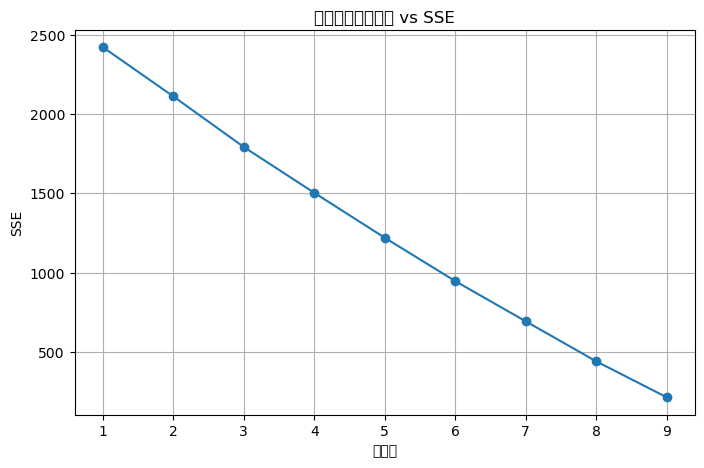

In [18]:
# 定义一个范围来测试不同的聚类数
range_n_clusters = range(1,10)
sse = []

# 计算每个聚类数下的SSE
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_fea_stan)
    sse.append(kmeans.inertia_)

# 绘制肘部图
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, sse, marker='o')
plt.title('肘部法则：聚类数 vs SSE')
plt.xlabel('聚类数')
plt.ylabel('SSE')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()



#聚类分析

In [19]:
# 根据肘部图选择最佳聚类数
n_clusters=best_n_clusters = 5# 根据图形选择最佳聚类数
# K-Means 聚类
kmeans = KMeans(n_clusters, init='k-means++', n_init=10, random_state=42)
#这个方法执行 K-Means 聚类，首先拟合模型，然后返回每个样本的簇标签（即组号）
K_result = kmeans.fit_predict(all_fea_stan)
print(K_result)

[2 1 0 4 3 0 2 1 2 2]


In [20]:
# 将聚类结果添加到 DataFrame
df['组号'] = K_result
df.head()


,基础信息,出行关注点,文本,时空信息,性别,lan_info,组号
0,"{'id': '1', '名字': '小明', '性别': '男'}","[安全, 省时, 不便于行(老人,小孩)]","[今天早上开车去公司，路上车不多。, 打算晚上去健身房后和朋友小聚。, 周末计划带孩子去游乐...","[{'时间': '2024.10.05 08am', '出发点': {'地点': '自家',...",男,早上 开车 公司 路上车 打算 晚上 健身房 朋友 小聚 周末 计划 孩子 游乐园 提前 买...,2
1,"{'id': '2', '名字': '小红', '性别': '女'}","[重物, 安全, 省钱]","[今天早上搭地铁去学校，列车很准时。, 下午和朋友约好去电影院看电影。, 昨天在超市买菜，发...","[{'时间': '2024.10.06 07am', '出发点': {'地点': '宿舍',...",女,早上 搭 地铁 学校 列车 准时 下午 朋友 约 电影院 电影 昨天 超市 买菜 发现 特价...,1
2,"{'id': '3', '名字': '李伟', '性别': '男'}","[安全, 愉悦, 准时]","[今天早晨开车去医院，交通顺畅。, 准备晚上和家人一起去餐厅吃饭。, 最近发现一家不错的咖啡...","[{'时间': '2024.10.07 06am', '出发点': {'地点': '家', ...",男,早晨 开车 医院 交通 顺畅 晚上 家人 餐厅 吃饭 发现 一家 不错 咖啡馆 计划 孩子 ...,0
3,"{'id': '4', '名字': '张婷', '性别': '女'}","[准时, 愉悦, 安全]","[早晨乘公交去办公室，路上还算顺利。, 中午和同事一起去餐厅吃饭。, 下班后准备去附近的瑜伽...","[{'时间': '2024.10.08 09am', '出发点': {'地点': '家', ...",女,早晨 公交 办公室 路上 算 顺利 中午 同事 餐厅 吃饭 下班 瑜伽 馆 听说 公司 有家...,4
4,"{'id': '5', '名字': '王强', '性别': '男'}","[教育意义, 重物, 不便于行(老人,小孩)]","[今天乘地铁去学校上课，地铁很拥挤。, 中午在餐厅吃午饭，同事推荐的不错。, 放学后常去附近...","[{'时间': '2024.10.09 08am', '出发点': {'地点': '家', ...",男,地铁 学校 上课 地铁 拥挤 中午 餐厅 吃 午饭 同事 推荐 不错 放学 后常去 图书馆 ...,3


#提取每个组别的特征值

In [21]:
# 构建小组标签池(表格)
gro_fea = pd.DataFrame(columns=['组号', '安全', '省钱', '愉悦', '准时', '教育意义', '不便于行'])

##计算特征值函数(等待改进,或者外接算法或者用chatgpt判断)

In [22]:
# 定义用于根据聚类计算特征值的函数!!!!!!
def calculate_features(cluster_data):
    # 在实际应用中，基于数据计算出下面的特征
    安全 = 1  if (cluster_data['性别'] == '女' or 
             '安全' in cluster_data['文本'] or 
             '盛世' in cluster_data['文本']) else 0
    省时 = 1 if ('着急' in cluster_data['文本'] or 
             '效率' in cluster_data['文本'] or 
             '省钱' in cluster_data['文本'] or 
             '赶时间' in cluster_data['文本'] or 
             '抓紧' in cluster_data['文本'] or 
             '等待' in cluster_data['文本']) else 0
    省钱 = 1 if ('没钱' not in cluster_data['文本'] or 
              '省钱' in cluster_data['文本']) else 0
    愉悦 = 1 if ('喜欢' in cluster_data['文本'] or 
              '愉悦' in cluster_data['文本'] or 
              '享受' in cluster_data['文本']) else 0
    重物 = 1 if ('小孩' in cluster_data['文本'] or 
              '重物' in cluster_data['文本'] or 
              '行李' in cluster_data['文本']) else 0

    准时 = 1 if ('上学' in cluster_data['文本'] or 
              '准时' in cluster_data['文本'] or 
              '按时' in cluster_data['文本']) else 0
    教育意义 =1 if ('学习' in cluster_data['文本'] or 
                '小孩' in cluster_data['文本'] or 
                '教育' in cluster_data['文本'] or 
                '知识' in cluster_data['文本']) else 0
    不便于行 = 1 if ('孩子' in cluster_data['文本'] or 
                '老人' in cluster_data['文本'] or 
                '不便' in cluster_data['文本']) else 0

    return [安全, 省时, 省钱, 愉悦, 重物, 准时, 教育意义, 不便于行]

##计算小组特征值-加权平均

In [23]:
# 用于收集每个组的计算结果
result_rows = []

# 为每个组计算特征
for cluster in df['组号'].unique():
    # 获取该组的所有成员
    cluster_members = df[df['组号'] == cluster]

    # 初始化存储特征值的列表
    features_list = []

    for _, member in cluster_members.iterrows():
        # 计算每个成员的特征
        features = calculate_features(member)
        features_list.append(features)

    # 将特征值转化为 numpy 数组
    features_array = np.array(features_list)

    # 计算平均值
    weighted_mean = np.mean(features_array, axis=0)

    # 将结果添加到 result_rows 中
    result_rows.append({'组号': cluster, **dict(zip(gro_fea.columns[1:], weighted_mean))})

# 将结果行转化为 DataFrame
gro_fea = pd.DataFrame(result_rows)

# 打印结果
print(gro_fea)

   组号    安全   省钱   愉悦   准时  教育意义  不便于行
0   2  0.25  0.0  1.0  0.0   0.0   0.0
1   1  1.00  0.0  1.0  0.0   0.0   0.0
2   0  0.00  0.0  1.0  0.0   0.0   0.0
3   4  1.00  0.0  1.0  0.0   0.0   0.0
4   3  0.00  0.0  1.0  0.0   0.0   0.0


#输出csv群组特征表格

In [24]:
#输出列表
# 将信息转换为 DataFrame
output_df_gro_fea = pd.DataFrame(gro_fea)

# 打印 DataFrame 验证
print(output_df_gro_fea)

# 保存 DataFrame 为 CSV 文件
output_df_gro_fea.to_csv('output/gro_fea_output.csv', index=False, encoding='utf-8-sig')

   组号    安全   省钱   愉悦   准时  教育意义  不便于行
0   2  0.25  0.0  1.0  0.0   0.0   0.0
1   1  1.00  0.0  1.0  0.0   0.0   0.0
2   0  0.00  0.0  1.0  0.0   0.0   0.0
3   4  1.00  0.0  1.0  0.0   0.0   0.0
4   3  0.00  0.0  1.0  0.0   0.0   0.0


##需求转换

#结果:输出每位用户的组别和特征值-csv

In [25]:
# 初始化列表用于存储最终信息
output_data = []

# 为每位用户生成信息
for index, row in df.iterrows():
    # 获取用户的基础信息
    user_info = row['基础信息']
    ID = user_info['id']
    name = user_info['名字']
    group_id=row['组号']

    # 获取用户的出行关注点!!!!!
    #foc_fea = ', '.join(row['出行关注点'])

  # 合并用户数据和特征数据
    user_data = {
        'ID': ID,
        '名字': name,
        #'出行关注点': foc_fea,!!!!
        '组号': group_id
    }

    output_data.append(user_data)

# 将信息转换为 DataFrame
output_df = pd.DataFrame(output_data)

# 打印 DataFrame 验证
print(output_df)

# 保存 DataFrame 为 CSV 文件
output_df.to_csv('output/user_info_output.csv', index=False, encoding='utf-8-sig')

   ID  名字  组号
0   1  小明   2
1   2  小红   1
2   3  李伟   0
3   4  张婷   4
4   5  王强   3
5   6  刘勇   0
6   7  张杰   2
7   8  赵敏   1
8   9  孙莉   2
9  10  周涛   2
